# GAN review

## Problem Setup
Let $x$ be element from the data space and let $z$ be an element from the latent space. 
In GAN, we have a discriminator $D(x;\theta_d)$ and generator $G(z;\theta_g)$. 
The generator $G(z;\theta_g)$ generates fake data, which depends on the latent variable $z$ that is sampled from noise prior $p_z(z)$.
The discriminator $D(x;\theta_d)$ examines an element from the data space and returns a probability that it is real or fake.
The goal is to train the $G$ and the $D$ such that each becomes good at its task. 

## Algorithm
repeat k times:
> **For discriminator:** \
    sample m noise values $\{ z_1, ..., z_m \}$ from noise prior $p_g(z)$ \
    sample m examples $\{ x_1, ..., x_m \}$ from data set. \
    update discriminator parameters $\theta_d$ using loss function $-\frac{1}{m} \sum_{i=1}^{m} [\log D(x_i) + \log(1-D(G(z_i)))]$ \
  **For generator:** \
    sample m noise values $\{ z_1, ..., z_m \}$ from noise prior $p_g(z)$ \
    update generator parameters $\theta_g$ using loss function $\frac{1}{m} \sum_{i=1}^m \log(1-D(G(z_i)))$
    In practice, we use $\frac{1}{m} \sum_{i=1}^m \log(D(G(z_i)))$, which provides larger gradient to the generator.
    This is because during the initial phase of the training, the discriminator has easier time distinguishing the fake data from real data, 
    Therefore, D(G) tends to be small, and $\log(D(G))$ provides larger gradient than $\log (1-D(G))$ during the initial phase of training (see loss graph)
> 

## Notes
Let $x=g(z)$, $p_g(x)dx=p_z(z)dz$ (as an integration measure): $p_g(x)$ is the probability distribution of fake data generated by $G$. Ideally, we have $p_g=p_{data}$

In [1]:
# Setup environment
from matplotlib import pyplot as plt
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
import datetime
from tqdm import tqdm
from maxout import Maxout
device = torch.device('cuda' if torch.cuda.is_available()
                     else torch.device('cpu'))
print(f"Training on {device}.")

Training on cuda.


In [2]:
# load data
batch_size=128

# normalize image such that the pixels lie between -1 and 1 (generator outputs lie between -1 and 1)
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST_data', train=True, download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,))
                   ])),
    batch_size=batch_size, shuffle=True,pin_memory=True) 
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST_data', train=False, download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,))
                    ])),
    batch_size=batch_size, shuffle=True, pin_memory=True)

### Notes
We provide fully connected network and maxout network for discriminator. The original paper uses maxout network (with a slightly different design).

In [3]:
class generator(nn.Module):
    """ The generator network in GAN
    
        Args:
            z_dim: dimension of latent space
            G_h1_dim: dimension of first hidden layer
            G_h2_dim: dimension of second hidden layer
            G_h3_dim: dimension of third hidden layer
            G_out_dim: dimension of output space (for MNIST, this should be 28*28)
        
        Returns:
            subclass of nn.Module: generator network"""
    def __init__(self,z_dim,G_h1_dim, G_h2_dim, G_h3_dim, G_out_dim):
        super().__init__()
        self.G_FC1 = nn.Linear(z_dim, G_h1_dim)
        self.G_FC2 = nn.Linear(G_h1_dim, G_h2_dim)
        self.G_FC3 = nn.Linear(G_h2_dim,G_h3_dim)
        self.G_FC4 = nn.Linear(G_h3_dim,G_out_dim)
        self._init_weights(irange=0.05)
    def _init_weights(self,irange):
        """Overrides built-in initialization. The original paper uses irange of 0.05"""
        for m in self.modules():
            if type(m) in {nn.Linear}:
                nn.init.uniform_(m.weight.data,-irange,irange)
                if m.bias is not None:
                    torch.zero_(m.bias.data)
    def forward(self,z_in):
        out = F.relu(self.G_FC1(z_in))
        out = F.relu(self.G_FC2(out))
        out = F.relu(self.G_FC3(out))
        out = torch.tanh(self.G_FC4(out))
        return out

    
class discriminator(nn.Module):
    """ The discriminator network in GAN
    
        Args:
            mode: for fully connected, use 'FC' and for maxout, use 'MO'
            x_dim: dimension of input (for MNIST, this should be 28*28)
            D_h1_dim: dimension of first hidden layer
            D_h2_dim: dimension of second hidden layer
            D_h3_dim: dimension of third hidden layer
        
        Returns:
            subclass of nn.Module: discriminator network"""
    def __init__(self,mode,x_dim,D_h1_dim,D_h2_dim,D_h3_dim):
        super().__init__()
        self.mode = mode
        self.x_dim = x_dim
        if self.mode == 'FC':
            self.D_FC1 = nn.Linear(x_dim,D_h1_dim)
            self.D_FC2 = nn.Linear(D_h1_dim,D_h2_dim)
            self.D_FC3 = nn.Linear(D_h2_dim,D_h3_dim)
            self.D_FC4 = nn.Linear(D_h3_dim,1)
        elif self.mode == 'MO':        
            self.D_MO1 = Maxout(x_dim,D_h1_dim,5)
            self.D_MO2 = Maxout(D_h1_dim,D_h2_dim,5)
            self.D_MO3 = Maxout(D_h2_dim,D_h3_dim,5)
            self.D_FC1 = nn.Linear(D_h3_dim,1)
        else:
            raise NotImplementedError
        self._init_weights(irange=0.005)
    def _init_weights(self,irange):
        """Overrides built-in initialization. The original paper uses irange of 0.005"""
        for m in self.modules():
            if type(m) in {nn.Linear}:
                nn.init.uniform_(m.weight.data,-irange,irange)
                if m.bias is not None:
                    torch.zero_(m.bias.data)
    def forward(self,x_in):
        if self.mode == 'FC':
            out = F.relu(self.D_FC1(x_in))
            out = F.dropout(out,p=0.3)
            out = F.relu(self.D_FC2(out))
            out = F.dropout(out,p=0.3)
            out = F.relu(self.D_FC3(out))
            out = F.dropout(out,p=0.3)
            out = self.D_FC4(out)
            out = torch.sigmoid(out)
        elif self.mode == 'MO':
            out = F.dropout(self.D_MO1(x_in.view(-1,self.x_dim)),p=0.3)
            out = F.dropout(self.D_MO2(out),p=0.3)
            out = F.dropout(self.D_MO3(out),p=0.3)
            out = self.D_FC1(out)
            out = torch.sigmoid(out)
        else:
            raise NotImplementedError
        return out

def noise(batch_size,z_dim,device):
    return torch.randn(batch_size,z_dim,device=device)

z_dim=100

gen = generator(z_dim=z_dim,G_h1_dim=256,G_h2_dim=512,G_h3_dim=1024,G_out_dim=28*28).to(device)

dis = discriminator(mode='MO',x_dim=28*28,D_h1_dim=512,D_h2_dim=256,D_h3_dim=128).to(device)

# dis = discriminator(mode='FC',x_dim=28*28,D_h1_dim=1048,D_h2_dim=512,D_h3_dim=256).to(device)

In [4]:
optimizer_D = optim.Adam(dis.parameters(),lr = 0.0001)
optimizer_G = optim.Adam(gen.parameters(),lr = 0.0001)
def train_discriminator(imgs,train=True):
    """Train the discriminator network
    
    Args:
        imgs: minibatch of images
        train: when set to False, used for validation
        
    Returns:
        mean loss
    """
    if train:
        gen.eval(), dis.train()
        noise_d = noise(batch_size,z_dim,device)
        loss_real = -torch.log(dis(imgs.view(-1,28*28))).mean()
        loss_fake = -torch.log(1.-dis(gen(noise_d))).mean()
        loss_d = loss_real+loss_fake
        optimizer_D.zero_grad()
        loss_d.backward()
        optimizer_D.step()
    else:
        gen.eval(), dis.eval()
        noise_d = noise(batch_size,z_dim,device)
        loss_real = -torch.log(dis(imgs.view(-1,28*28))).mean()
        loss_fake = -torch.log(1.-dis(gen(noise_d))).mean()
        loss_d = loss_real+loss_fake
    return loss_d.detach()
def train_generator(imgs,train=True):
    """Train the generator network
    
    Args:
        imgs: minibatch of images
        train: when set to false, used for validation
        
    Returns:
        mean loss
    """
    if train:
        gen.train(), dis.eval()
        noise_g = noise(batch_size,z_dim,device)
        loss_g = -torch.log(dis(gen(noise_g))).mean()
        optimizer_G.zero_grad()
        loss_g.backward()
        optimizer_G.step()
    else:
        gen.eval(), dis.eval()
        noise_g = noise(batch_size,z_dim,device)
        loss_g = -torch.log(dis(gen(noise_g))).mean()
    return loss_g.detach()
    
def training_loop(epochs,test = False):
    """Train generator and discriminator
    Args:
        epochs: number of epochs 
        test: if True, evaluate on validation set
    
    Returns:
        List of average loss per epoch. 
        If test is True, also returns list of average loss for test set.
        The first element in the list contains the discriminator loss,
        the second element in the list contains the generator loss.
    """
    loss_list_trn = [[],[]]
    loss_list_val = [[],[]]
    for epoch in tqdm(range(epochs),desc = f'percent of epochs completed'):
        for imgs, label in train_loader:
            loss_d_batch_list_trn = []
            loss_g_batch_list_trn = []
            imgs = imgs.to(device)
            loss_d_batch_trn=train_discriminator(imgs)
            loss_g_batch_trn=train_generator(imgs)
            loss_d_batch_list_trn.append(loss_d_batch_trn.item())
            loss_g_batch_list_trn.append(loss_g_batch_trn.item())
        loss_list_trn[0].append(np.mean(loss_d_batch_list_trn))
        loss_list_trn[1].append(np.mean(loss_g_batch_list_trn))
        if test:
            with torch.no_grad():
                for imgs, label in test_loader:
                    loss_d_batch_list_val = []
                    loss_g_batch_list_val = []
                    imgs = imgs.to(device)
                    loss_d_batch_val = train_discriminator(imgs,train=False)
                    loss_g_batch_val = train_generator(imgs,train=False)
                    loss_d_batch_list_val.append(loss_d_batch_val.item())
                    loss_g_batch_list_val.append(loss_g_batch_val.item())
                loss_list_val[0].append(np.mean(loss_d_batch_list_val))
                loss_list_val[1].append(np.mean(loss_g_batch_list_val))
    return loss_list_trn, loss_list_val

In [5]:
# print("training loop starting at",datetime.datetime.now())
loss_list = training_loop(epochs=100,test=True)
# print("finished training loop at",datetime.datetime.now())

percent of epochs completed: 100%|█████████| 100/100 [1:52:23<00:00, 67.43s/it]


In [6]:
# how well does discriminator distinguish real from fake and how well does generator fool the discriminator?
dis.eval()
gen.eval()
for imgs,_ in train_loader:
    imgs=imgs.to(device)
    print(dis(imgs.view(-1,28*28)).mean(),dis(gen(noise(100,z_dim,device))).mean())
    break
for imgs,_ in test_loader:
    imgs=imgs.to(device)
    print(dis(imgs.view(-1,28*28)).mean(),dis(gen(noise(100,z_dim,device))).mean())
    break

tensor(0.6999, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.3315, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6449, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.2810, device='cuda:0', grad_fn=<MeanBackward0>)


## Notes
Notice that the discriminator loss increase slightly.
This is because initially, the discriminator has an easy time distinguishing the randomly generated fake image from real ones.
However, the generator soon learns to fool the discriminator, and we reach an equilibrium.

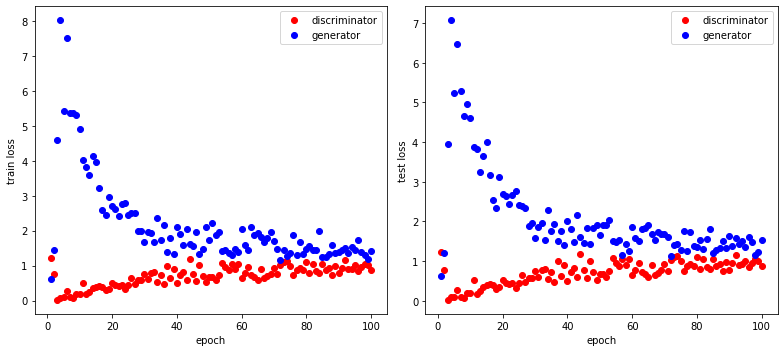

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(11,5))
ax[0].plot(range(1,len(loss_list[0][0])+1),loss_list[0][0],'.r',label = 'discriminator',markersize=12)
ax[0].plot(range(1,len(loss_list[0][1])+1),loss_list[0][1],'.b',label = 'generator',markersize=12)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('train loss')
ax[0].legend()
ax[1].plot(range(1,len(loss_list[1][0])+1),loss_list[0][0],'.r',label = 'discriminator',markersize=12)
ax[1].plot(range(1,len(loss_list[1][1])+1),loss_list[1][1],'.b',label = 'generator',markersize=12)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('test loss')
ax[1].legend()
plt.tight_layout()

In [8]:
# save model
torch.save(gen.state_dict(),'gen_MO.pth')
torch.save(dis.state_dict(),'dis_MO.pth')

In [9]:
def generate_img(gen,n_img):
    from torchvision.utils import save_image
    gen.eval()
    generated = gen(noise(n_img,z_dim,device))
    generated=generated.detach().view(n_img,1,28,28).to('cpu')
    print(generated.shape)
    with torch.no_grad():
        save_image(generated,'gen_MO_img.pdf')
#         for i in range(10):
#             plt.imshow(np.array(a[i].view(28,28).detach().to('cpu')),cmap='gray')
#             plt.show()
generate_img(gen,10)

torch.Size([10, 1, 28, 28])
